<a href="https://colab.research.google.com/github/mikelabadie/Earnings_Call_Transcripts/blob/master/analysis_topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preprocessing: Tools

#### Main Imports

In [0]:
! pip install pyLDAvis

from IPython.display import clear_output

import numpy as np
import nltk
nltk.download('wordnet')

import spacy
spacynlp = spacy.load('en_core_web_sm')

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

nltk.download('stopwords')

from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

import string
exclude = set(string.punctuation)

from nltk.stem.wordnet import WordNetLemmatizer

lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    stop_free = stop_free.replace("-", " ")
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized 
  
clear_output()

#### Get CIK for a Ticker

In [0]:
from bs4 import BeautifulSoup
import requests
from urllib.parse import urlparse

def get_CIK(ticker):
    URL = "https://www.sec.gov/cgi-bin/browse-edgar?CIK="+ticker+"&owner=exclude&action=getcompany"
    page = requests.get(URL)
    soup = BeautifulSoup(page.text, "html.parser")
    CIK = soup.find(attrs={"name": "CIK"})
    return CIK["value"]

#### Functions to Plot Heatmap and Get the Line Items from Financial Statements for a Ticker

In [0]:
import seaborn as sns

def make_heatmap(results):
    fig = plt.figure(figsize=(10,6))
  
    inc_lines_in_call = results.sum().sort_values()
    inc_lines_in_call = inc_lines_in_call[inc_lines_in_call > 0].index.values

    if inc_lines_in_call.any():
        sns.heatmap(results[inc_lines_in_call].T)
    else:
        sns.heatmap(results.T)
    
    plt.show()
    
def get_inc_stmt_lines(ticker):
    cik=str(int(get_CIK(ticker)))
    items_to_find = df_fin_stmt_items[df_fin_stmt_items["cik"]==cik]
    #net_inc = items_to_find[items_to_find["plabel"].str.match("[N|n]et.*[I|i]ncome")]["line"].min()
    #items_to_find = items_to_find[items_to_find["line"]<=net_inc]
    items_to_find = list(items_to_find["plabel"])+list(items_to_find["tlabel"])

    items_to_find = [item.lower().replace(",","") for item in items_to_find]
    #items_to_find += [item.replace("profit","margin") for item in items_to_find if "profit" in item]
    #items_to_find += ["of sales","of revenues","of revenue"]
    #items_to_find += [item.replace("net ","") for item in items_to_find if "net" in item]
    
    return list(np.unique(items_to_find))

## Preprocessing: Bring in Data


In [0]:
data_directory = "/content/gdrive/My Drive/DATS6450 - Labadie - Data/"

#### Read Call Pickle and Build Meta-data and Text DataFrames

In [3]:
# import the call dataset
import pandas as pd
import numpy as np
import pickle
import os

from google.colab import drive
drive.mount('/content/gdrive')

if os.path.exists(data_directory+"ProcessedCallsPickleUpdated_v2"):
    pfile = open(data_directory+"ProcessedCallsPickleUpdated_v2", "rb")
    calls = pickle.load(pfile)                 
    pfile.close()
    
df_metadata = calls["metadata"]
df_text = calls["text"]
  
clear_output()

print("Metadata Shape:",df_metadata.shape, "Text Shape:",df_text.shape)

Metadata Shape: (5101, 6) Text Shape: (640132, 11)


#### List of Companies and Industries/Sectors

In [4]:
company_list = pd.read_csv(data_directory+"companylist.csv")
company_list.shape

(5285, 9)

#### Tickers -> CIK:  Used to connect to financial statements from SEC

In [5]:
cik_ticker_map = pd.read_csv(data_directory+"cik_ticker.csv",sep="|",dtype={"CIK":object})
cik_ticker_map.shape

(13737, 8)

#### Financial Statement Data

In [0]:
#%%
directory=data_directory+"2018q4/"

filename = directory + "sub.txt"
df_sub = pd.read_table(filename,dtype={"cik":object})
#df_sub=df_sub.merge(cik_ticker_map,left_on=["cik"],right_on=["CIK"],how="left")

filename = directory + "tag.txt"
df_tag = pd.read_table(filename,dtype={"cik":object})

filename = directory + "pre.txt"
df_pre = pd.read_table(filename,dtype={"cik":object})

filename = directory + "num.txt"
df_num = pd.read_table(filename,dtype={"cik":object})

df_fin_stmt = df_sub.merge(df_pre).merge(df_num).merge(df_tag)
df_fin_stmt_items = df_fin_stmt[df_fin_stmt["stmt"]=="IS"][["cik","line","plabel","tlabel"]].drop_duplicates()

## Preprocessing: Create a List of Tickers to Analyze

In [7]:
industry="Industrial Machinery/Components"
ticker_list = list(company_list[(company_list["Industry"]==industry)]["Symbol"])

calls_to_use = df_metadata[(df_metadata["ticker"].isin(ticker_list))].sort_values(by=["ticker"])
print("Number of Calls:",calls_to_use.shape[0])

Number of Calls: 183


## Topic Modeling:  Analyze Paragraphs using Financial Statements

#### Build Line Items Vocabulary

In [0]:
line_items = []

num_calls = -1
for _, row in calls_to_use[0:num_calls].iterrows():
    line_items+=get_inc_stmt_lines(row["ticker"])
    
line_items=set(line_items)

max_ngram = np.max([len(item.split()) for item in line_items])
min_ngram = np.min([len(item.split()) for item in line_items])

#### Manual Adds to Vocabulary

In [0]:
line_items.add("tax cuts")
line_items.add("tariff")
line_items.add("tariffs")
line_items.add("white house")
line_items.add("ebitda")
line_items.add("ebitda margins")
line_items.add("ebitda margin")

#### Perform Cleaning of a Paragraph Based on Financial "Lingo"

In [0]:
def clean_paragraph(paragraph):
    #paragraph = paragraph.replace(" of revenue"," ").replace(" of revenues"," ").replace(" of sales"," ")
    return paragraph

#### Analyze Usage of Terms from Financial Statements on Earnings Calls
This looks across all calls and builds a dictionary of all the terms used both in financial statements and earnings.

In [0]:
prepared_remarks = df_text[(df_text["Call Section"]=="Prepared Remarks")&
                           (df_text["Speaker"]!="Operator")&
                           (df_text["ticker"].isin(ticker_list))]

corpus = list(prepared_remarks["Text"])
corpus = [clean_paragraph(paragraph) for paragraph in corpus]

tfidf_vectorizer = TfidfVectorizer(ngram_range=(min_ngram, max_ngram),vocabulary=line_items)
tfidf = tfidf_vectorizer.fit_transform(corpus)

results = pd.DataFrame(data=tfidf.toarray(), index=prepared_remarks.index.values, columns=tfidf_vectorizer.get_feature_names())
inc_lines_in_call = results.sum().sort_values()
inc_lines_in_call = list(inc_lines_in_call[inc_lines_in_call > 0].index.values)
results = results[inc_lines_in_call]

In [0]:
fig = plt.figure(figsize=(15,15))
x = results.iloc[0:25,]
sns.heatmap(x)
plt.show()

#### Heatmap of Term by Paragraph

https://www.fool.com/earnings/call-transcripts/2018/11/01/aaon-inc-aaon-q3-2018-earnings-conference-call-tra.aspx


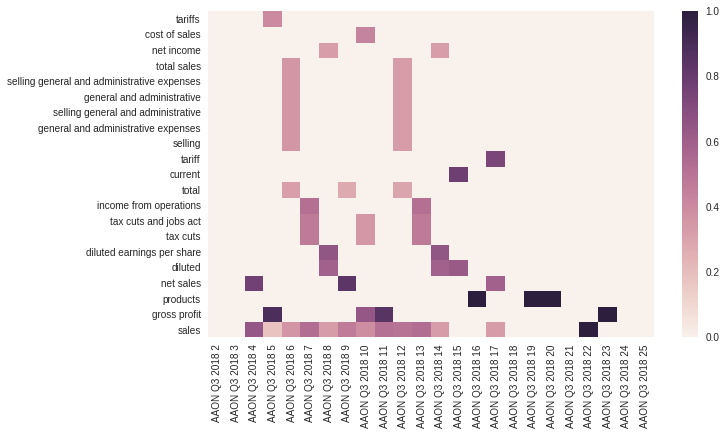


https://www.fool.com/earnings/call-transcripts/2019/03/02/aaon-inc-aaon-q4-2018-earnings-conference-call-tra.aspx


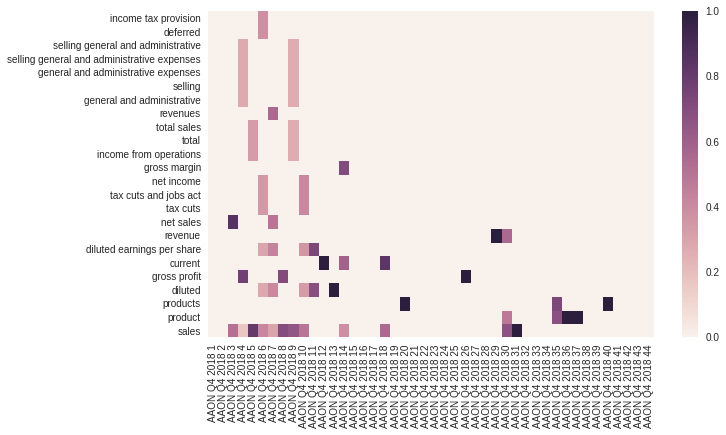

In [257]:
num_calls = 2
for _, row in calls_to_use[0:num_calls].iterrows():
    print(row.name)
    prepared_remarks = df_text[(df_text["Call Section"]=="Prepared Remarks")&
                               (df_text["Speaker"]!="Operator")&
                               (df_text["Link"]==row["Link"])]
    
    corpus = list(prepared_remarks["Text"])
    corpus = [clean_paragraph(paragraph) for paragraph in corpus]
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(min_ngram, max_ngram),vocabulary=line_items)
    tfidf = tfidf_vectorizer.fit_transform(corpus)

    results = pd.DataFrame(data=tfidf.toarray(), index=prepared_remarks.index.values, columns=tfidf_vectorizer.get_feature_names())
    make_heatmap(results)    
    print()

## Topic Modeling:  Assign a Topic to Each Paragraph

#### Add to Stop Lists Based on Companies

In [0]:
removal_list = ["The","International","Incorporated","Inc","Corporation","Corp","Group","Holdings","Company","Co.","Brands",".",",","&"]
#removal_list += ["Restaurants","Restaurant","Stores","Store"]

def clean_company_name(name):
    for item in removal_list:
        name = name.replace(item,"")
    return name.strip()

company_stop_words = np.unique([clean_company_name(x) for x in calls_to_use["company"].values])

In [0]:
#[stop.add(x) for x in company_stop_words]

#### Build Corpus

In [13]:
corpus, named_ents, call_names, paragraph_nums, corpus_whole_calls, call_names_whole_calls = [], [], [], [], [], []

num_calls = 2
for _, row in calls_to_use[0:num_calls].iterrows():
    print(row["Link"])
    prepared_remarks = df_text[df_text["Link"]==row["Link"]]
    prepared_remarks = prepared_remarks[(prepared_remarks["Call Section"]=="Prepared Remarks")&(prepared_remarks["Speaker"]!="Operator")]
    
    #corpus += list(prepared_remarks["Cleaned Text"])
    cleaned_text_for_call = [clean(paragraph) for paragraph in prepared_remarks["Text"]]
    corpus += cleaned_text_for_call
    
    for paragraph in prepared_remarks["Text"]:
        ents = spacynlp(paragraph).ents
        named_ents.append([ent.text.replace("\n","").upper() for ent in ents])
    
    call_names += list(prepared_remarks.index)
    
    paragraph_nums  += list(prepared_remarks["Call Paragraph Num"])
    
    corpus_whole_calls.append(" ".join(cleaned_text_for_call))
    call_names_whole_calls.append(row["ticker"] + " " + row["period"])


https://www.fool.com/earnings/call-transcripts/2018/11/01/aaon-inc-aaon-q3-2018-earnings-conference-call-tra.aspx
https://www.fool.com/earnings/call-transcripts/2019/03/02/aaon-inc-aaon-q4-2018-earnings-conference-call-tra.aspx


#### Scikit Learn Topic Modeling

In [0]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [15]:
n_components = 25
n_top_words = 5

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

tfidf_vectorizer  = TfidfVectorizer(ngram_range=(1,1),min_df=0.001,max_df=0.25)
tfidf = tfidf_vectorizer .fit_transform(corpus)
nmf = NMF(n_components=n_components, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

W = nmf.fit_transform(tfidf)
df_topics = pd.DataFrame(W,index=call_names)

Topic #0: share per earnings diluted decreased
Topic #1: price increase backlog june weve
Topic #2: sga decrease expense increased percentage
Topic #3: tax rate effective decreased act
Topic #4: statement aaons looking forward including
Topic #5: 31 december increase net result
Topic #6: capital 31 balance december expenditure
Topic #7: gross profit quarter company compared
Topic #8: open question moderator ill that
Topic #9: lab believe exists anywhere ton
Topic #10: turn like detail discus id
Topic #11: young east debt deal day
Topic #12: september net 30 month mainly
Topic #13: market went 50 change commercial
Topic #14: another quarter one increase likewise
Topic #15: attractive customer upon 32 astoundingly
Topic #16: scheduled lab april utilization target
Topic #17: compounded aaon annual growth per
Topic #18: talk curve painstaking catching materialize
Topic #19: young woman instead appointed is
Topic #20: unit whats sold pace 115
Topic #21: this simultaneously senior stay clima

In [16]:
df_topics[4].sort_values(ascending=False).head(10)

AAON Q3 2018 2     1.177043
AAON Q4 2018 1     1.025454
AAON Q4 2018 2     0.519422
AAON Q4 2018 26    0.129147
AAON Q4 2018 7     0.000000
AAON Q4 2018 6     0.000000
AAON Q4 2018 5     0.000000
AAON Q4 2018 4     0.000000
AAON Q4 2018 3     0.000000
AAON Q4 2018 9     0.000000
Name: 4, dtype: float64

In [17]:
df_topics.loc["AAON Q4 2018 1",].sort_values(ascending=False).head(10)

4     1.025454
24    0.000000
11    0.000000
1     0.000000
2     0.000000
3     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
Name: AAON Q4 2018 1, dtype: float64

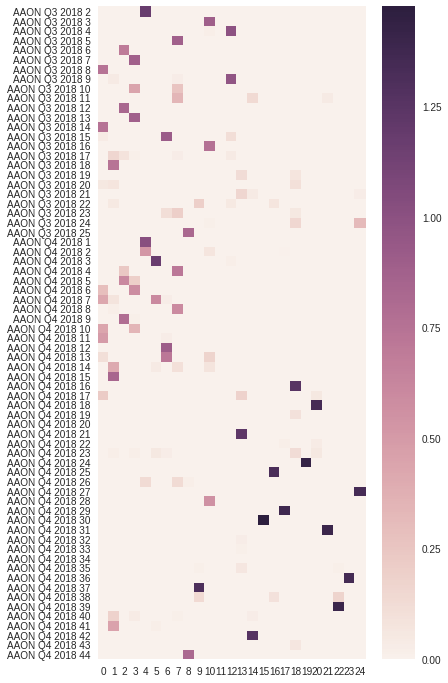

In [18]:
f,axs = plt.subplots(1,1,figsize=(6,12))
sns.heatmap(df_topics)

## Topic Modeling:  Text Summarization using Text Rank

In [0]:
! pip install summa
clear_output()

In [65]:
from summa import keywords
from summa.summarizer import summarize

corpus, named_ents, call_names, paragraph_nums, corpus_whole_calls, call_names_whole_calls = [], [], [], [], [], []

num_calls = 10
for _, row in calls_to_use[0:num_calls].iterrows():
    prepared_remarks = df_text[(df_text["Call Section"]=="Prepared Remarks")&
                               (df_text["Speaker"]!="Operator")&
                               (df_text["Link"]==row["Link"])]
    
    addl_stopwords = ["good","looking","like"]
    corpus += [keywords.keywords(paragraph, ratio=0.1, additional_stopwords=addl_stopwords).split() for paragraph in prepared_remarks["Text"]]   
    call_names += list(prepared_remarks.index)

pd.DataFrame(corpus,index=call_names)

,0,1,2,3,4,5,6,7
AAON Q3 2018 2,forward,necessarily,statement,None,None,None,None,None
AAON Q3 2018 3,None,None,None,None,None,None,None,None
AAON Q3 2018 4,comparative,None,None,None,None,None,None,None
AAON Q3 2018 5,profit,None,None,None,None,None,None,None
AAON Q3 2018 6,None,None,None,None,None,None,None,None
AAON Q3 2018 7,tax,None,None,None,None,None,None,None
AAON Q3 2018 8,share,shares,None,None,None,None,None,None
AAON Q3 2018 9,net,september,None,None,None,None,None,None
AAON Q3 2018 10,profit,None,None,None,None,None,None,None
AAON Q3 2018 11,company,None,None,None,None,None,None,None


## Next Technique:  Cross Document Structure

## Next Technique:  Text Tiling

## Next Technique:  Topic Tiling

## Next Technique:  Text Reuse (Croft)